In [2]:
import matplotlib.pyplot as plt
import scipy.io
import os
import numpy as np
from scipy.signal import butter, lfilter
from scipy import stats as st
from sklearn.svm import SVC  

In [3]:
def derivative(signal, fs):
    derivative_signal = np.diff(signal)
    return derivative_signal * fs

def squared(signal):
    squared_signal = signal ** 2
    return squared_signal

def moving_average(signal, window_size):
    window = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(signal, window, mode='same')
    return smoothed_signal
    
def pan_tompkins_qrs_detection(ecg_signal, fs):
    
    derivative_signal = derivative(ecg_signal, fs)
    
   
    squared_signal = squared(derivative_signal)
    
    window_size = int(0.1* fs) 
    integrated_signal = moving_average(squared_signal, window_size)
    
    threshold = 0.6 * max(integrated_signal)
    qrs_peaks = []
    for i in range(1, len(integrated_signal) - 1):
        if integrated_signal[i] > threshold and integrated_signal[i] > integrated_signal[i - 1] and integrated_signal[i] > integrated_signal[i + 1]:
            qrs_peaks.append(i)
    
    return qrs_peaks

In [4]:
def feature_extraction(data_matrix,fs):
    m,n=data_matrix.shape
    features=np.zeros([m,2])
    for i in range(m):
        qrs_peaks = pan_tompkins_qrs_detection(data_matrix[i,:], fs)
        rr_intervals = np.diff(np.array(qrs_peaks) / fs)
        rr_med=np.median(rr_intervals)
        energy=np.dot(data_matrix[i,:],data_matrix[i,:])*fs/(len(data_matrix[i,:]))
        features[i,:]=rr_med,energy
    return features

In [5]:
def design_notch_filter(f0, fs, Q):
    b, a = butter(2, [(f0 - 0.5)/fs, (f0 + 0.5)/fs], btype='bandstop', analog=False)
    return b, a
def design_bandpass_filter(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [6]:
def Preprocessing(data_list,fs):
    l=len(data_list)
    data_matrix=np.zeros([l,data_list[0].shape[0]])
    b1,a1=design_notch_filter(50,fs,30)
    b2,a2=design_bandpass_filter(0.25,40,fs,order=5)
    for i in range(l):
        data_matrix[i,:]=lfilter(b1,a1,data_list[i])
        data_matrix[i,:]=lfilter(b2,a2,data_matrix[i,:])
        data_matrix[i,:]=data_matrix[i,:]/np.max(np.abs(data_matrix[i,:]))
    return data_matrix

In [7]:
arrthymia_data=[]
a_l=os.listdir("/home/govind/BMSP/arrthymia_data")
for i in a_l:
    mat = scipy.io.loadmat(os.path.join("/home/govind/BMSP/arrthymia_data",i))
    keys_1=list(mat.keys())
    data=mat[keys_1[-1]]
    arrthymia_data.append(data[0,:])

FileNotFoundError: [Errno 2] No such file or directory: '/home/govind/BMSP/arrthymia_data'

In [8]:
normal_data=[]
n_l=os.listdir("/home/govind/BMSP/normal_data")
n_l.remove('qt_data')
for i in n_l:
    mat = scipy.io.loadmat(os.path.join("/home/govind/BMSP/normal_data",i))
    keys_1=list(mat.keys())
    data=mat[keys_1[-1]]
    normal_data.append(data[0,:])

FileNotFoundError: [Errno 2] No such file or directory: '/home/govind/BMSP/normal_data'

In [9]:
qt_data=[]
q_l=os.listdir("/home/govind/BMSP/normal_data/qt_data")
for i in q_l:
    mat = scipy.io.loadmat(os.path.join("/home/govind/BMSP/normal_data/qt_data",i))
    keys_1=list(mat.keys())
    data=mat[keys_1[-1]]
    qt_data.append(data[0,:])


FileNotFoundError: [Errno 2] No such file or directory: '/home/govind/BMSP/normal_data/qt_data'

In [ ]:
normal_data_matrix=Preprocessing(normal_data,fs=128)
arrthymia_data_matrix=Preprocessing(arrthymia_data,fs=360)
qt_data_matrix=Preprocessing(qt_data,fs=250)

In [ ]:
normal_data_features=feature_extraction(normal_data_matrix,fs=128)
arrthymia_data_features=feature_extraction(arrthymia_data_matrix,fs=360)
qt_data_features=feature_extraction(qt_data_matrix,fs=250)

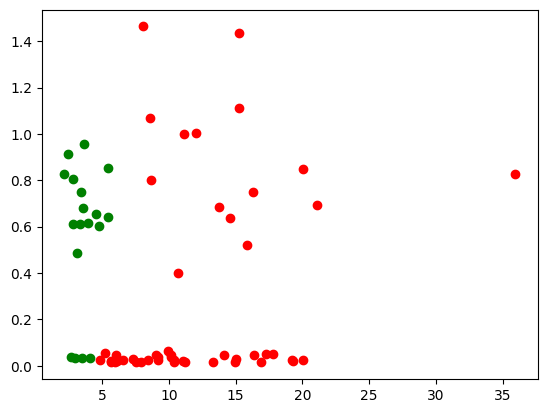

In [ ]:
plt.scatter(arrthymia_data_features[:,1],arrthymia_data_features[:,0],color='r')
plt.scatter(normal_data_features[:,1],normal_data_features[:,0],color='g')
#plt.scatter(qt_data_features[:,1],qt_data_features[:,0],color='g')

In [260]:
data_matrix=np.zeros([66,2])

In [272]:
data_matrix[0:48,:]=arrthymia_data_features
data_matrix[48:66,:]=normal_data_features
y_label=np.ones(66)
y_label[48:66]=-1

In [307]:
model = SVC(kernel='rbf')  
model.fit(data_matrix, y_label) 

SVC()